* Compare total volumn and fresh water transport across different river flow conditions.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools)
import datetime, os
from glob import glob
from nowcast import figures
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from R_mixStuff import sites
from R_mixStuff import strings
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

In [2]:
transects = {'1':{'jst':55, 'ist':25,'jen':56,'ien':80},
            '2':{'jst':25, 'ist':25,'jen':26,'ien':75},
            '3':{'jst':25, 'ist':25,'jen':56,'ien':26},
            '4':{'jst':37, 'ist':72,'jen':45,'ien':73},
            '5':{'jst':120, 'ist':138,'jen':121,'ien':139}}

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][380:510,240:397]
Y = grid6.variables['nav_lat'][380:510,240:397]
bathy = grid6.variables['Bathymetry'][380:510,240:397]

In [4]:
## mask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
umask = mesh.variables['umask'][0,:,380:510,240:397]
vmask = mesh.variables['vmask'][0,:,380:510,240:397]
e3u = mesh.variables['e3u'][0,:,380:510,240:397]
e3v = mesh.variables['e3v'][0,:,380:510,240:397]
e3t = mesh.variables['e3t'][0,:,380:510,240:397]
e2t = mesh.variables['e2t'][0,380:510,240:397]
e1t = mesh.variables['e1t'][0,380:510,240:397]
np_mask = np.abs(1-tmask) 

(48.95, 49.7)

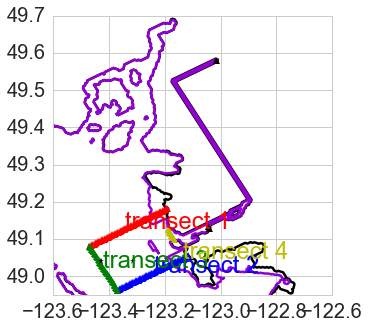

In [5]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
ax.plot(X[55,25:80],Y[55,25:80],'r^')
ax.plot(X[25,25:75],Y[25,25:75],'b^')
ax.plot(X[25:56,25],Y[25:56,25],'g^')
ax.plot(X[37:45,72],Y[37:45,72],'y^')
ax.plot(X[34:36,94],Y[34:36,94],'k^')
ax.plot(X[120:121,155],Y[120:121,155],'k^')
ax.plot(X[sites['VENUS Central']['j'],sites['VENUS Central']['i']],\
         Y[sites['VENUS Central']['j'],sites['VENUS Central']['i']],'k*')
ax.plot(X[sites['VENUS East']['j'],sites['VENUS East']['i']],\
         Y[sites['VENUS East']['j'],sites['VENUS East']['i']],'k*')
ax.annotate ('transect 1',(X[55,50],Y[55,50]), xycoords="data",color = 'r')
ax.annotate ('transect 2',(X[25,50],Y[25,50]), xycoords="data",color = 'b')
ax.annotate ('transect 3',(X[40,25],Y[40,25]), xycoords="data",color = 'g')
ax.annotate ('transect 4',(X[25,70],Y[25,70]), xycoords="data",color = 'y')
ax.set_xlim([-123.6,-122.6])
ax.set_ylim([48.95,49.7])

In [6]:
## load salinity into a dict
pathsoct = ['Oct2014OnlyRiver','Oct2014notides','Oct2014nowind','Oct2014nof','Oct2014combineall']
pathsmay = ['May2015OnlyRiver','May2015notides','May2015nowind','May2015nof','May2015combineall']
pathsjan = ['Jan2016OnlyRiver','Jan2016notides','Jan2016nowind','Jan2016nof','Jan2016combineall']
base='/data/jieliu/MEOPAR/SurfaceCurrent/'
file_patternTs = ['oct2014*_T.nc','may2015*_T.nc','jan2016*_T.nc']
file_patternUs = ['oct2014*_U.nc','may2015*_U.nc','jan2016*_U.nc']
file_patternVs = ['oct2014*_V.nc','may2015*_V.nc','jan2016*_V.nc']
U = {}; V={}; S={};ssh = {}
paths = [pathsoct,pathsmay,pathsjan]
for paa,Tfile, Ufile,Vfile in zip(paths,file_patternTs,file_patternUs,file_patternVs):
    for pa in paa:
        pathT = glob(os.path.join(base,pa, Tfile))
        pathU = glob(os.path.join(base,pa, Ufile))
        pathV = glob(os.path.join(base,pa, Vfile))
        fU = nc.Dataset(pathU[0],'r');
        U[pa] = fU.variables['vozocrtx']
        fV = nc.Dataset(pathV[0],'r');
        V[pa] = fV.variables['vomecrty']
        depU = fU.variables['depthu']
        depV = fV.variables['depthv']
        fT = nc.Dataset(pathT[0],'r');
        S[pa] = fT.variables['vosaline']
        lon = fT.variables['nav_lon'] 
        lat = fT.variables['nav_lat']
        ssh[pa] = fT.variables['sossheig']
        time_counter = fT.variables['time_counter']

In [7]:
def transport_calculate_general(S,U,V,ssh,lon,lat,depU,depV,tran,t_st,t_en,paths,fresh_flag = False,\
                                y0lim =6e5, y1lim = 6000):
    """to calculate the total transport (False)or fresh water transport (True) in the entire water column 
    with focus on a continous time period rather than a specific time"""
    UU = {}; VV= {};SS={}
    jinds = np.arange(transects[tran]['jst'],transects[tran]['jen']+1)
    iinds = np.arange(transects[tran]['ist'],transects[tran]['ien']+1)
    for pa in paths:
        SS[pa] = np.zeros([time_counter.shape[0],depU.shape[0],jinds.shape[0],iinds.shape[0]])
        UU[pa] = np.zeros([time_counter.shape[0],depU.shape[0],jinds.shape[0]-1,iinds.shape[0]-1])
        VV[pa] = np.zeros([time_counter.shape[0],depV.shape[0],jinds.shape[0]-1,iinds.shape[0]-1])
        for t in np.arange(t_st[pa],t_en[pa]+1):
            SS[pa][t] = S[pa][t,:,jinds,iinds]    
            mask=np_mask[:,jinds[0]:jinds[-1]+1,iinds[0]:iinds[-1]+1]
            SS[pa][t] = np.ma.masked_array(SS[pa][t],mask=mask) ## mask sal=0 by tmask 
                    
                               
            UU[pa][t],VV[pa][t] = viz_tools.unstagger(U[pa][t,:,jinds,iinds],\
                                      V[pa][t,:,jinds,iinds])
    trans,trans_sur,trans_to = transport_time_general(SS,UU,VV,ssh,lon,lat,depU,depV,tran,t_st,t_en,\
                                                 paths,fresh_flag = fresh_flag) ## get surface/total transport
        ## location
    return trans,trans_sur,trans_to

In [8]:
def transport_time_general(S,U,V,ssh,lon,lat,depU,depV,tran,t_st,t_en,paths,fresh_flag = False):
    """This function was made to calculate total 
    transport/fresh water transport during a continuous 
    period, rather than the specific time """
    trans = {}; trans_surf = {}; trans_total ={}
    if tran =='3' or tran =='4' or tran =='5': ## cross-shelf transport
        for pa in paths:
            trans[pa] = np.zeros([time_counter.shape[0],depU.shape[0],np.arange(transects[tran]['jen']-transects[tran]['jst']).shape[0]])
            for t in np.arange(t_st[pa],t_en[pa]+1):
                for z in np.arange(depU.shape[0]):
                    for j in np.arange(transects[tran]['jen']-transects[tran]['jst']):
                        d = e2t[j+transects[tran]['jst'],transects[tran]['ist']]
                        if fresh_flag == False:
                            ratio = 1
                        else:
                            ratio = (30 - S[pa][t,z,j,0])/30
                        adj_ssh = 1+ssh[pa][t,j+transects[tran]['jst'],transects[tran]['ist']]\
                        /np.sum(e3t[:,j+transects[tran]['jst'],\
                        transects[tran]['ist']]*tmask[:,j+transects[tran]['jst'],transects[tran]['ist']])

                        trans[pa][t,z,j] = U[pa][t,z,j,0]*d*e3t[z,j+transects[tran]['jst']+1,transects[tran]['ist']+1]*adj_ssh*ratio
    else: ## along-shore transport
        for pa in paths:
            trans[pa]= np.zeros([time_counter.shape[0],depV.shape[0],np.arange(transects[tran]['ien']-transects[tran]['ist']).shape[0]]);
            for t in np.arange(t_st[pa],t_en[pa]+1):
                for z in np.arange(depV.shape[0]):
                    for i in np.arange(transects[tran]['ien']-transects[tran]['ist']):
                        d = e1t[transects[tran]['jst'],i+transects[tran]['ist']]
                        if fresh_flag == False:
                            ratio = 1
                        else:
                            ratio = (30 - S[pa][t,z,0,i])/30

                        adj_ssh = 1+ssh[pa][t,transects[tran]['jst'],i+transects[tran]['ist']]\
                        /np.sum(e3t[:,transects[tran]['jst'],i+transects[tran]['ist']]*tmask[:,transects[tran]['jst'],i+transects[tran]['ist']])

                        trans[pa][t,z,i] = V[pa][t,z,0,i]*d*e3t[z,transects[tran]['jst']+1,i+transects[tran]['ist']+1]*adj_ssh*ratio ## shape of [40,54]
    ## surface and total transport in the dict
    for pa in paths:
        trans_surf[pa] = np.nansum(trans[pa][t_st[pa]:t_en[pa]+1,0,:],axis = 1)
        trans_total[pa] = np.nansum(np.nansum(trans[pa][t_st[pa]:t_en[pa]+1],axis = 1),axis = 1)
 
    return trans, trans_surf,trans_total

In [9]:
def plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,paths,fresh_flag = True,y1lim = 4000):
    """This function was made to plot the fresh water transport/total water transport
        over a period of time for a specific run case over different river flows conditions"""
    trans,trans_surf,trans_to = transport_calculate_general(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,\
                                                                   paths,fresh_flag = fresh_flag)
    fig, axs = plt.subplots(2,1,figsize = (12,10))
    ax= axs[0]
    for pa in paths:
        ax.plot(ssh[pa][tst[pa]:ten[pa]+1,86,89],label = pa)
    ax.set_ylabel('ssh at PA [m]')
    ax = axs[1]
    for pa in paths:
        ax.plot(trans_to[pa],'-^',label = pa)
        ax.legend(loc = 'best')
        if fresh_flag == True:
            ax.set_ylabel('total fresh water flux $m^{3}s^{-1}$')
        else:
            ax.set_ylabel('total volume flux $m^{3}s^{-1}$')
    ax.set_ylim([-y1lim,y1lim])
    ax.set_xlabel('time [hr]')

* only river

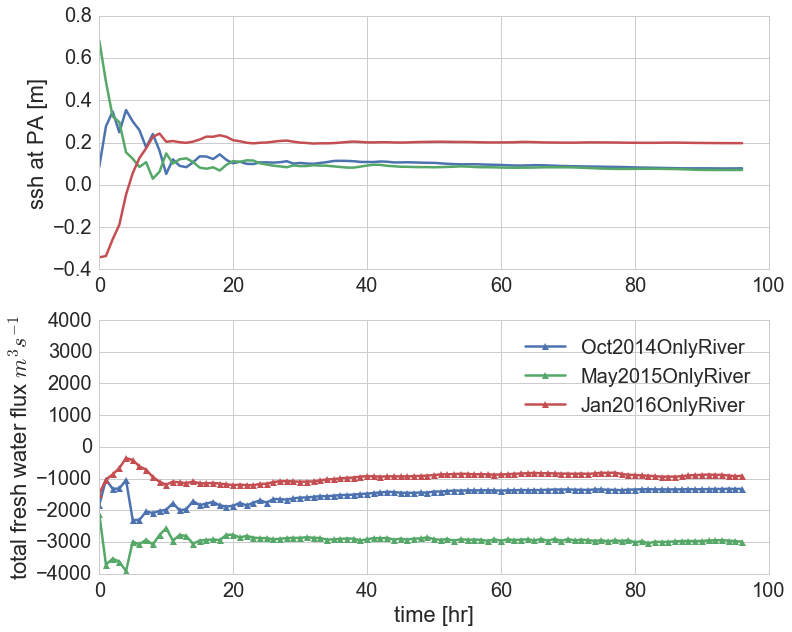

In [10]:
paths = ['Oct2014OnlyRiver','May2015OnlyRiver','Jan2016OnlyRiver']
tst = {'Oct2014OnlyRiver':0,'May2015OnlyRiver':0,'Jan2016OnlyRiver':0}
ten = {'Oct2014OnlyRiver':96,'May2015OnlyRiver':96,'Jan2016OnlyRiver':96}
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'4',tst,ten,paths,fresh_flag = True)

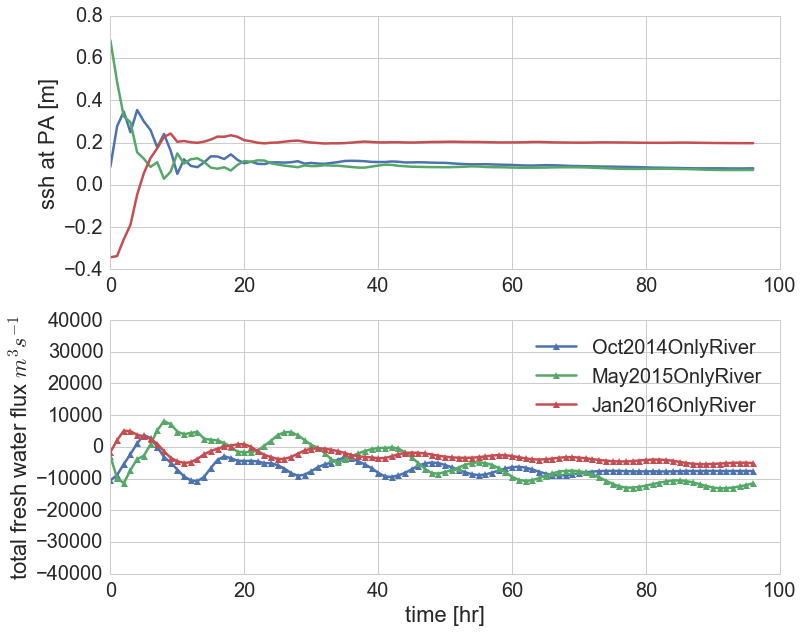

In [20]:
paths = ['Oct2014OnlyRiver','May2015OnlyRiver','Jan2016OnlyRiver']
tst = {'Oct2014OnlyRiver':0,'May2015OnlyRiver':0,'Jan2016OnlyRiver':0}
ten = {'Oct2014OnlyRiver':96,'May2015OnlyRiver':96,'Jan2016OnlyRiver':96}
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'1',tst,ten,paths,fresh_flag = True,y1lim = 4e4)

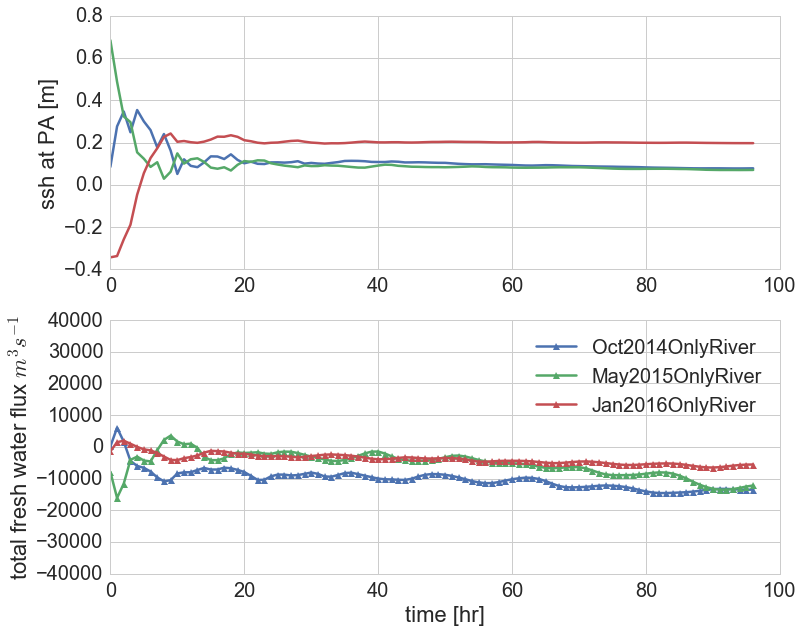

In [21]:
paths = ['Oct2014OnlyRiver','May2015OnlyRiver','Jan2016OnlyRiver']
tst = {'Oct2014OnlyRiver':0,'May2015OnlyRiver':0,'Jan2016OnlyRiver':0}
ten = {'Oct2014OnlyRiver':96,'May2015OnlyRiver':96,'Jan2016OnlyRiver':96}
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'2',tst,ten,paths,fresh_flag = True,y1lim = 4e4)

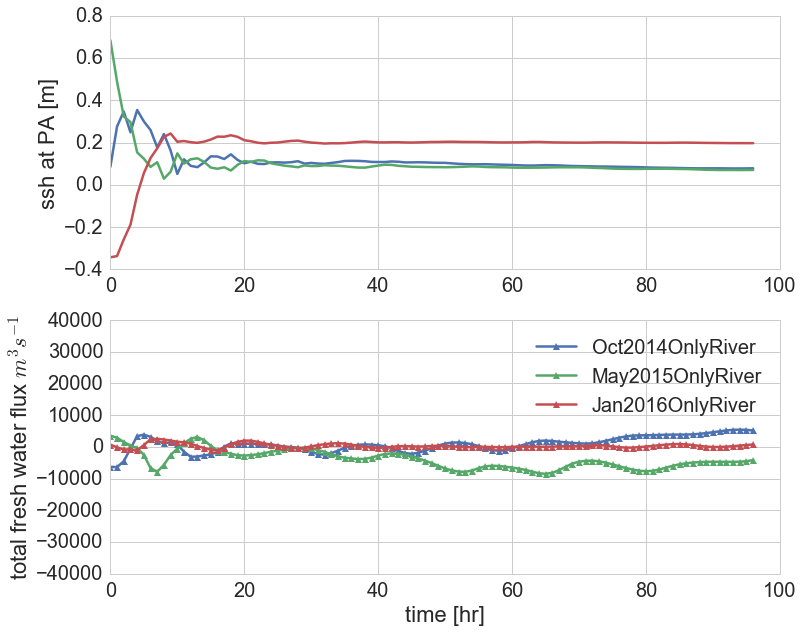

In [22]:
paths = ['Oct2014OnlyRiver','May2015OnlyRiver','Jan2016OnlyRiver']
tst = {'Oct2014OnlyRiver':0,'May2015OnlyRiver':0,'Jan2016OnlyRiver':0}
ten = {'Oct2014OnlyRiver':96,'May2015OnlyRiver':96,'Jan2016OnlyRiver':96}
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'3',tst,ten,paths,fresh_flag = True,y1lim = 4e4)

* No wind

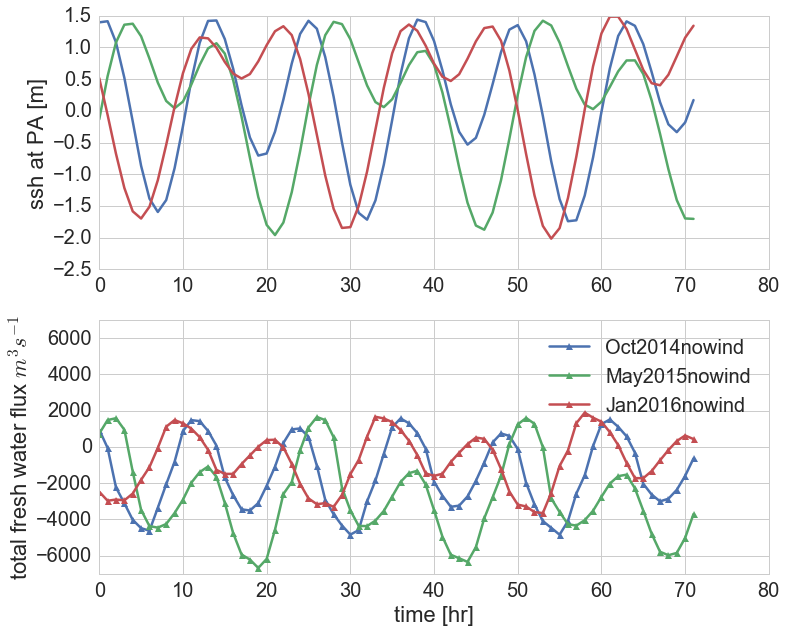

In [14]:
paths = ['Oct2014nowind','May2015nowind','Jan2016nowind'] ## oct 9~11,may 7~9,jan 7~9 spring 
tst = {'Oct2014nowind':192,'May2015nowind':144,'Jan2016nowind':144}
ten = {'Oct2014nowind':263,'May2015nowind':215,'Jan2016nowind':215}
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'4',tst,ten,paths,fresh_flag = True,y1lim=7000)

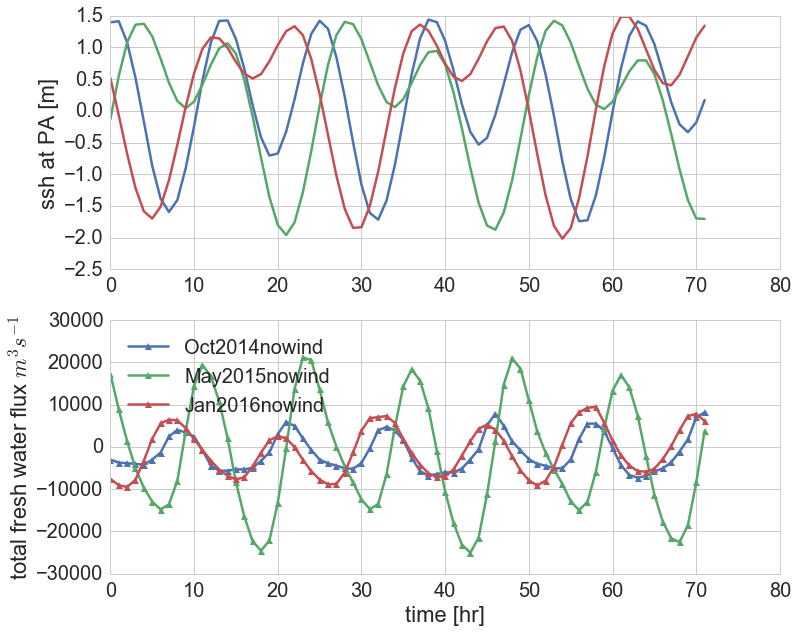

In [15]:
paths = ['Oct2014nowind','May2015nowind','Jan2016nowind'] ## oct 9~11,may 7~9,jan 7~9 spring 
tst = {'Oct2014nowind':192,'May2015nowind':144,'Jan2016nowind':144}
ten = {'Oct2014nowind':263,'May2015nowind':215,'Jan2016nowind':215}
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'1',tst,ten,paths,fresh_flag = True,y1lim=3e4)

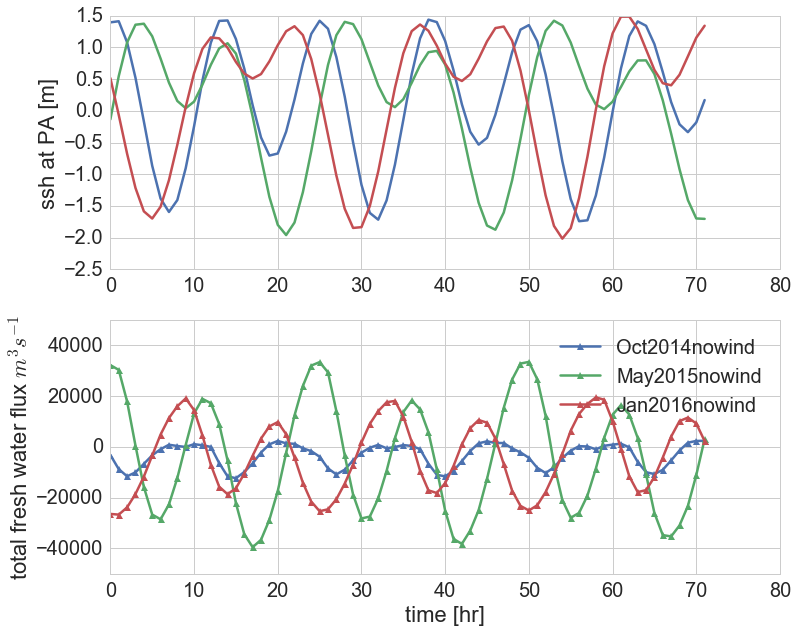

In [23]:
paths = ['Oct2014nowind','May2015nowind','Jan2016nowind'] ## oct 9~11,may 7~9,jan 7~9 spring 
tst = {'Oct2014nowind':192,'May2015nowind':144,'Jan2016nowind':144}
ten = {'Oct2014nowind':263,'May2015nowind':215,'Jan2016nowind':215}
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'2',tst,ten,paths,fresh_flag = True,y1lim=5e4)

* combine all

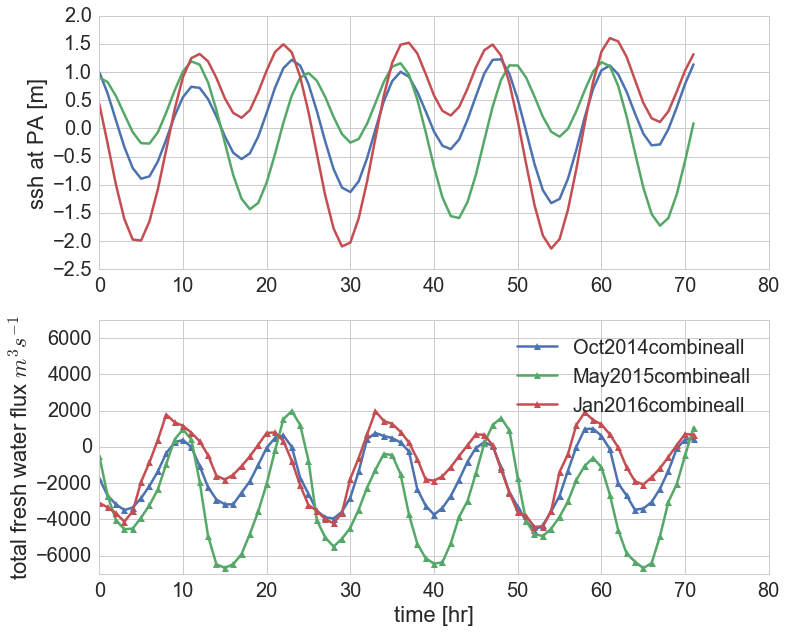

In [17]:
paths = ['Oct2014combineall','May2015combineall','Jan2016combineall'] ## oct 21~23,may 2~4,jan 21~23 strong winds 
tst = {'Oct2014combineall':480,'May2015combineall':24,'Jan2016combineall':480}
ten = {'Oct2014combineall':551,'May2015combineall':95,'Jan2016combineall':551}
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'4',tst,ten,paths,fresh_flag = True,y1lim=7000)

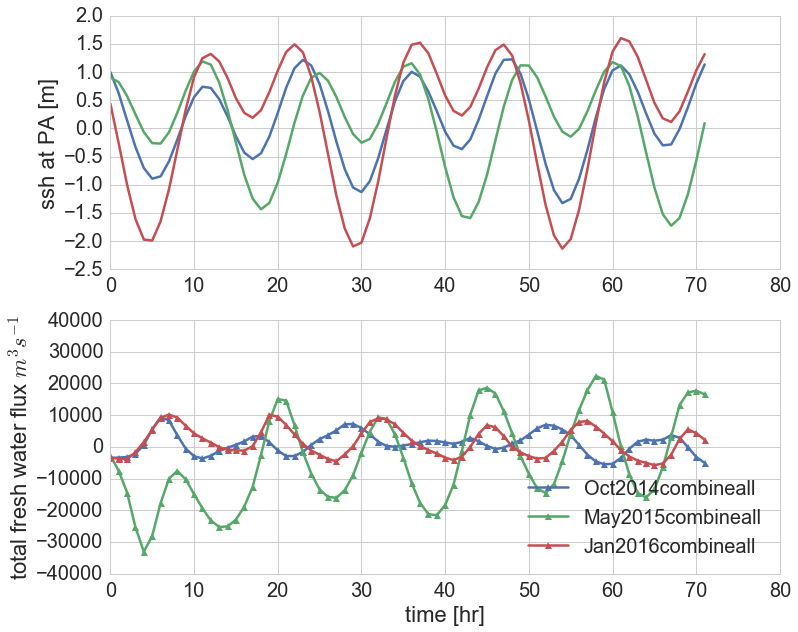

In [24]:
paths = ['Oct2014combineall','May2015combineall','Jan2016combineall'] ## oct 21~23,may 2~4,jan 21~23 strong winds 
tst = {'Oct2014combineall':480,'May2015combineall':24,'Jan2016combineall':480}
ten = {'Oct2014combineall':551,'May2015combineall':95,'Jan2016combineall':551}
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'1',tst,ten,paths,fresh_flag = True,y1lim=4e4)

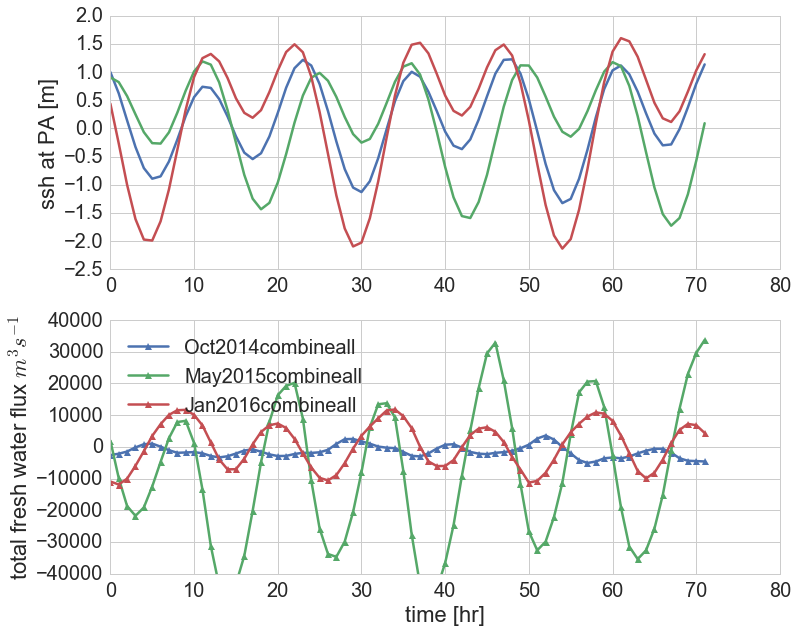

In [25]:
paths = ['Oct2014combineall','May2015combineall','Jan2016combineall'] ## oct 21~23,may 2~4,jan 21~23 strong winds 
tst = {'Oct2014combineall':480,'May2015combineall':24,'Jan2016combineall':480}
ten = {'Oct2014combineall':551,'May2015combineall':95,'Jan2016combineall':551}
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'2',tst,ten,paths,fresh_flag = True,y1lim=4e4)